### Background:
Author--:   Daniel Maina Nderitu -----  Designation--:   Data Scientist </br> 
Project--:   MADIVA - Stroke Data Processing Pipeline  --- Year----:   2025 </br> </br>
Path (/home/dmaina)

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# Display options
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.max_rows', 100)       # Optional: increase max rows
pd.set_option('max_colwidth', None)          # Show full content of each column

### Import data (df (derived columns) and df_ind_ses)

In [2]:
df = pd.read_csv('/dataA/madiva/data/dmac/extractions/p2_stroke_20250624.csv')
df_ind_ses = pd.read_csv('/dataA/madiva/data/dmac/extractions/p2_stroke_ses_20250506.csv')
df_cod = pd.read_csv('/dataA/madiva/data/dmac/extractions/p2_stroke_cod_20250628.csv') # Cause of death (cod) data
print("Rows--Columns----------------------------------------------------")
print("-------------------NCD data -------------------------------------")
print(df.shape)
print("-------------------Individual SES data --------------------------")
print(df_ind_ses.shape)
print("-------------------Causes of death (COD) ------------------------")
print(df_cod.shape)

Rows--Columns----------------------------------------------------
-------------------NCD data -------------------------------------
(47405, 99)
-------------------Individual SES data --------------------------
(1288374, 8)
-------------------Causes of death (COD) ------------------------
(4900, 8)


### Process dataframes
#### Sort

In [3]:
df.sort_values(by=['individual_id', 'obs_date', 'age'], inplace=True)
df_ind_ses.sort_values(by=['individual_id', 'obs_date'], inplace=True)
df_cod.sort_values(by=['individual_id'], inplace=True)

In [4]:
# df.head()
# Viewing columns 
cols = df.columns.tolist()
for i in range(0, len(cols), 7):  # change 5 to 10 or any chunk size
    print(cols[i:i+7])

['individual_id', 'age', 'dod', 'sex', 'obs_date', 'source', 'hdss_name']
['alco_ever', 'alco_12m', 'alco_30d', 'alco_bing_y', 'tobac_ever', 'tobac_cur', 'tobac_smkls_ever']
['tobac_p_daily', 'tobac_freq', 'fd_fruitservings', 'fd_meals_outhome_ave', 'fd_diet_change', 'fd_fruit_days', 'fd_veg_days']
['fd_eat_drink_12h', 'fd_oil_type', 'fd_veg_servings', 'actv_walk_bicycle_days', 'actv_vigorous_sports_min', 'actv_mpa_minutes', 'actv_moderate_sports_hrs']
['actv_vigorous_sports', 'actv_mpa_days', 'actv_vpa_days', 'actv_sitting_or_standing', 'actv_walk_bicycle_min', 'actv_vpa_hrs', 'actv_walk_bicycle_hrs']
['actv_walk_bicycle', 'actv_moderate_sports_days', 'actv_mpa_hrs', 'actv_sitting_min', 'actv_moderate_sports_min', 'actv_sleeping_hrs', 'actv_vigorous_sports_days']
['actv_moderate_sports', 'actv_vpa_minutes', 'actv_vpa', 'actv_mpa', 'actv_vigorous_sports_hrs', 'actv_mvpa', 'actv_sitting_hrs']
['stroke_ever', 'stroke_numb', 'stroke_wkness', 'stroke_paralysis_ever', 'stroke_blind', 'strok

#### Mapping / replacing values

In [5]:
mapping_educ_years = {-8: -333,-9: -888, -10: -999}
df_ind_ses['education_years'] = df_ind_ses['education_years'].map(mapping_educ_years).fillna(df_ind_ses['education_years'])
mapping_educ_level = {    -8: 333,    -9: 888,    -10: 999}
df_ind_ses['education_level'] = df_ind_ses['education_level'].map(mapping_educ_level).fillna(df_ind_ses['education_level'])
mapping_mar_status = {    -8: 333,    -9: 888,    -10: 999}
df_ind_ses['marital_status'] = df_ind_ses['marital_status'].map(mapping_mar_status).fillna(df_ind_ses['marital_status'])

### Utility Functions <br>
#### Global Values - constants

In [6]:
# Priority order for collapsing categorical data
PRIORITY_ORDER = [1, 0, 333, 444, 888, 999]
invalid_codes = [-999, -888, -444, -333, 444, 888, 999]
collapse_vars = ["alcohol_use", "tobacco_use", "hpt_status_derived", "diab_status_derived", "stroke_status_derived", "hiv_test_result"]
collapse_vars_addition = ["education_level","education_years","marital_status","currently_working"]
sociodemographics = ["source","sex", "age", "obs_date", "source", "hdss_name", ]  # ,"source","hdss_name"

#### collapse_to_ever_had

In [7]:
# Utility: Prioritize values for collapsing (1 > 0 > 333 > 444 > 888 > 999 > NaN)
# The second purpose of this function is to collapse multiple records if an individual into 1
def collapse_to_ever_had(df, individual_id, variable):    
    def prioritize(values):
        # PRIORITY_ORDER = [1, 0, 333, 444, 888, 999]
        for val in PRIORITY_ORDER:
            if val in values:
                return val
        return np.nan
    return df.groupby(individual_id)[variable].apply(lambda x: prioritize(x.dropna().unique())).reset_index()

#### prioritize function - standalone

In [8]:
# Function to prioritize categorical variables
def prioritize_values(values):
    for val in PRIORITY_ORDER:
        if val in values:
            return val
    return np.nan

#### Food and fruit intake function

In [9]:
bins = [0, 1, 5, 10, 20, 30, 40, 50, 59, np.inf]
group_labels = ['0 (None)', '1-4 (Very Low)', '5-9 (Low)', '10-19 (Moderate)', '20-29 (High)', '30-39 (Very High)', '40-49 (Extreme)'
                , '50-59 (Maximum)', '60+ (Exceptional)']

def create_intake_groups(series):
    """Handle NULL/999 values before binning"""
    return np.where(
        series.isna() | (series == 999),  # Condition for NULL/999
        'Missing (No data)',                # Special category
        pd.cut(
            series,
            bins=bins,
            labels=group_labels,
            right=False
        ).astype(str)  # Convert to string to combine with missing category
    )

#### Alcohol use

In [10]:
def determine_alcohol_use(row):
    vars = ["alco_12m", "alco_30d", "alco_bing_y"]
    values = row[vars]
    if (values == 1).sum() > 0:
        return 1
    elif (values == 0).sum() > 0:
        return 0
    for code in [333, 444, 888, 999]:
        if (values == code).sum() > 0:
            return -10  #code (initial returning value)
    
    # Only if nothing else matches, check for NULLs (last step)
    if values.isnull().any():
        return -10 #888
    
    return np.nan

#### Tobacco use

In [11]:
def determine_tobacco_use(row):
    vars = ["tobac_ever", "tobac_cur", "tobac_smkls_ever", "tobac_p_daily"] # , "tobac_freq"
    values = row[vars]
    if (values == 1).sum() > 0:
        return 1
    elif (values == 0).sum() > 0:
        return 0
    for code in [333, 444, 888, 999]:
        if (values == code).sum() > 0:
            return -10 # code
    return np.nan

#### Diet

In [12]:
# df[['fd_fruit_days', 'fd_fruitservings', 'fd_meals_outhome_ave', 'fd_diet_change', 'fd_veg_days', 'fd_eat_drink_12h', 'fd_oil_type','fd_veg_servings']].head()
def process_diet_data(df, individual_id="individual_id"):
    # Handle categorical variables
    cat_vars = ["fd_diet_change", "fd_eat_drink_12h"]
    collapsed_cats = []
    for var in cat_vars:
        collapsed = collapse_to_ever_had(df, individual_id, var)
        collapsed.columns = [individual_id, var]
        collapsed_cats.append(collapsed)    
    # Handle numeric and composite variables
    # Exclude special codes for calculations
    special_codes = [333, 444, 888, 999, -333, -444, -888, -999]
    df_filtered = df[~df["fd_fruit_days"].isin(special_codes) & ~df["fd_fruitservings"].isin(special_codes)].copy()
    df_filtered["total_fruit_intake"] = df_filtered["fd_fruit_days"] * df_filtered["fd_fruitservings"]
    fruits = df_filtered.groupby(individual_id)["total_fruit_intake"].sum().reset_index()    
    df_filtered = df[~df["fd_veg_days"].isin(special_codes) & ~df["fd_veg_servings"].isin(special_codes)].copy()
    df_filtered["total_veg_intake"] = df_filtered["fd_veg_days"] * df_filtered["fd_veg_servings"]
    vegetables = df_filtered.groupby(individual_id)["total_veg_intake"].sum().reset_index()    
    df_filtered = df[~df["fd_meals_outhome_ave"].isin(special_codes)].copy()
    meals_outside = df_filtered.groupby(individual_id)["fd_meals_outhome_ave"].mean().reset_index()
    # Merge all processed variables
    final_df = pd.DataFrame({individual_id: df[individual_id].unique()})
    for component in collapsed_cats + [fruits, vegetables, meals_outside]:
        final_df = final_df.merge(component, on=individual_id, how="left")    
    # Return processed data
    return final_df

#### Physical activity

In [13]:
# Variables ('actv_walk_bicycle_days', 'actv_vigorous_sports_min',
    #    'actv_mpa_minutes', 'actv_moderate_sports_hrs', 'actv_vigorous_sports',
    #    'actv_mpa_days', 'actv_vpa_days', 'actv_sitting_or_standing',
    #    'actv_walk_bicycle_min', 'actv_vpa_hrs', 'actv_walk_bicycle_hrs',
    #    'actv_walk_bicycle', 'actv_moderate_sports_days', 'actv_mpa_hrs',
    #    'actv_sitting_min', 'actv_moderate_sports_min', 'actv_sleeping_hrs',
    #    'actv_vigorous_sports_days', 'actv_moderate_sports', 'actv_vpa_minutes',
    #    'actv_vpa', 'actv_mpa', 'actv_vigorous_sports_hrs', 'actv_mvpa',
    #    'actv_sitting_hrs',)
# Physical activity data - preview 
df[['actv_walk_bicycle_days', 'actv_vigorous_sports_min', 'actv_mpa_minutes', 'actv_moderate_sports_hrs', 'actv_vigorous_sports'
    , 'actv_mpa_days', 'actv_vpa_days', 'actv_sitting_or_standing', 'actv_walk_bicycle_min', 'actv_vpa_hrs', 'actv_walk_bicycle_hrs'
    , 'actv_walk_bicycle', 'actv_moderate_sports_days', 'actv_mpa_hrs', 'actv_sitting_min', 'actv_moderate_sports_min', 'actv_sleeping_hrs'
    , 'actv_vigorous_sports_days', 'actv_moderate_sports', 'actv_vpa_minutes', 'actv_vpa', 'actv_mpa', 'actv_vigorous_sports_hrs', 'actv_mvpa', 'actv_sitting_hrs']]

,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs
27633,7.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,2.0,1.0,-888.0,-888.0,NaN,NaN,12.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,5.0
27634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3767,-888.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,-888.0,0.0,-888.0,-888.0,NaN,NaN,11.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,3.0
3768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Missing values

In [14]:
# Count of missing values
missing_counts = df[['actv_walk_bicycle_days', 'actv_vigorous_sports_min', 'actv_mpa_minutes', 'actv_moderate_sports_hrs', 'actv_vigorous_sports'
    , 'actv_mpa_days', 'actv_vpa_days', 'actv_sitting_or_standing', 'actv_walk_bicycle_min', 'actv_vpa_hrs', 'actv_walk_bicycle_hrs', 'actv_walk_bicycle'
    , 'actv_moderate_sports_days', 'actv_mpa_hrs', 'actv_sitting_min', 'actv_moderate_sports_min', 'actv_sleeping_hrs', 'actv_vigorous_sports_days', 'actv_moderate_sports'
    , 'actv_vpa_minutes', 'actv_vpa', 'actv_mpa', 'actv_vigorous_sports_hrs', 'actv_mvpa', 'actv_sitting_hrs']].isnull().sum()
# Percent of missing values
missing_percent = df[['actv_walk_bicycle_days', 'actv_vigorous_sports_min', 'actv_mpa_minutes', 'actv_moderate_sports_hrs', 'actv_vigorous_sports', 'actv_mpa_days'
    , 'actv_vpa_days', 'actv_sitting_or_standing', 'actv_walk_bicycle_min', 'actv_vpa_hrs', 'actv_walk_bicycle_hrs', 'actv_walk_bicycle', 'actv_moderate_sports_days'
    , 'actv_mpa_hrs', 'actv_sitting_min', 'actv_moderate_sports_min', 'actv_sleeping_hrs', 'actv_vigorous_sports_days', 'actv_moderate_sports'
    , 'actv_vpa_minutes', 'actv_vpa', 'actv_mpa', 'actv_vigorous_sports_hrs', 'actv_mvpa', 'actv_sitting_hrs']].isnull().mean() * 100
# Combine into one DataFrame
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)
# Show top variables with most missing values
print(missing_summary.head(10))


                          missing_count  missing_percent
actv_moderate_sports_min          43579        91.929121
actv_sitting_or_standing          42346        89.328130
actv_mvpa                         40536        85.509967
actv_sleeping_hrs                 39438        83.193756
actv_sitting_min                  35011        73.855079
actv_walk_bicycle_min             33756        71.207679
actv_vigorous_sports_min          33756        71.207679
actv_mpa_minutes                  33756        71.207679
actv_vpa_minutes                  33756        71.207679
actv_moderate_sports_hrs          33124        69.874486


#### TB

In [15]:
##### Preview of our data
df[['individual_id', 'age', 'dod', 'sex', 'obs_date', 'source', 'hdss_name','stroke_status_derived', 'hiv_status_derived'
    , 'hpt_status_derived', 'obese_status_derived', 'diab_status_derived', 'tb_status_derived', 'bmi']].head()

,individual_id,age,dod,sex,obs_date,source,hdss_name,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi
27633,000025C5-5811-4942-8957-8A1A4FF1460F,35,NaN,2,2008-07-26,Assess Linkages Main,Nairobi,0.0,NaN,0,0.0,0,NaN,NaN
27634,000025C5-5811-4942-8957-8A1A4FF1460F,39,NaN,2,2012-09-30,SCALEUP Population Baseline,Nairobi,0.0,NaN,1,0.0,0,NaN,25.9187
10065,0004A623-93CA-4D53-B10C-805B27EFD98F,36,NaN,1,2012-08-26,SCALEUP Population Baseline,Nairobi,0.0,NaN,1,1.0,0,NaN,31.1690
3767,000D523D-F549-40B3-B8E1-2FF517084EB0,56,NaN,1,2008-04-30,Assess Linkages Main,Nairobi,0.0,NaN,1,0.0,0,NaN,NaN
3768,000D523D-F549-40B3-B8E1-2FF517084EB0,61,NaN,1,2012-08-24,SCALEUP Population Baseline,Nairobi,0.0,NaN,1,1.0,0,NaN,32.6677


#### BMI


In [16]:
# Define your continuous variables
continuous_vars = ['bmi', 'age']  # Add more if needed

# Create summary of missing counts and percentages
missing_counts = df[continuous_vars].isnull().sum()
missing_percent = df[continuous_vars].isnull().mean() * 100

# Combine into a DataFrame
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent.round(2)
}).sort_values(by='missing_percent', ascending=False)

# Show the summary
print(missing_summary)

     missing_count  missing_percent
bmi          17681             37.3
age              0              0.0


In [17]:
# Only include valid values
df['bmi_refined'] = df['bmi'].where(
    df['bmi'].notna() & ~df['bmi'].isin(invalid_codes) & (df['bmi'] <= 180)
).round(1)

# df_bmi =  df_bmi['bmi_rounded'] <= 70.00
# Step 3: Identify outliers using IQR
Q1 = df['bmi_refined'].quantile(0.25)
Q3 = df['bmi_refined'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add outlier flag
df['is_outlier'] = (df['bmi_refined'] < lower_bound) | (df['bmi_refined'] > upper_bound)

##### Comparing Agincourt and Nairobi

/tmp/ipykernel_553095/436158780.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hdss_name', y='bmi_refined', palette='Set2')


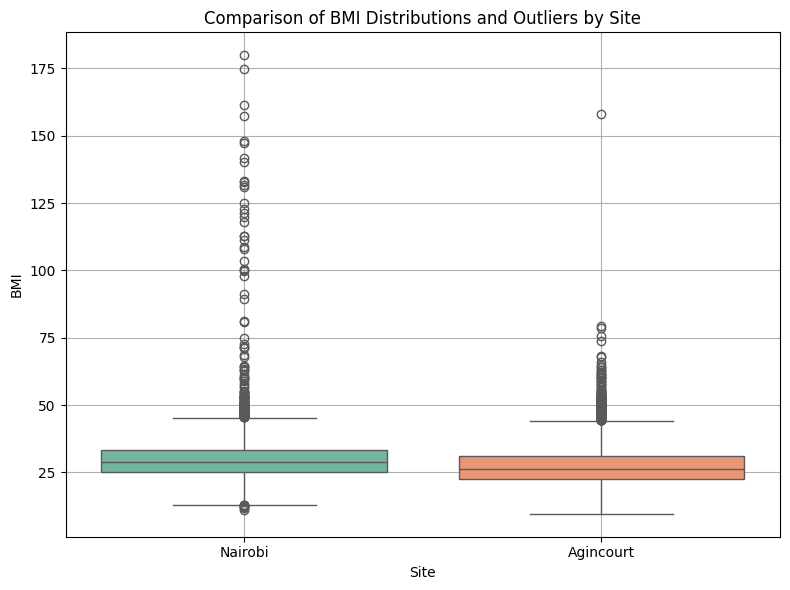

In [18]:
import seaborn as sns
# df_bmi[(df_bmi['bmi_rounded']>0) & (df_bmi['bmi_rounded']<100)]['bmi_rounded'].value_counts()
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='hdss_name', y='bmi_refined', palette='Set2')
plt.title("Comparison of BMI Distributions and Outliers by Site")
plt.xlabel("Site")
plt.ylabel("BMI")
plt.grid(True)
plt.tight_layout()
plt.show()

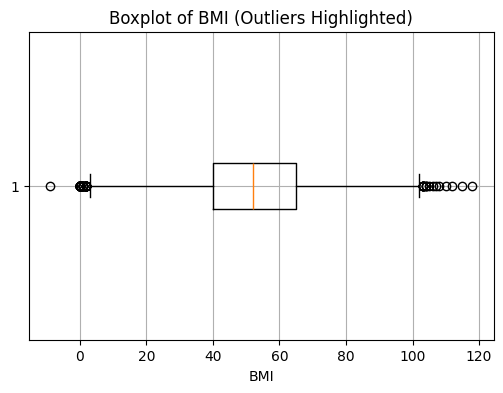

In [19]:
# Round to 2 decimal places
# df_bmi = df_bmi[df_bmi['is_outlier']==True]

df[['individual_id', 'age','sex', 'obs_date', 'bmi', 'bmi_refined']]

# Step 4: Visualize using boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(df['age'], vert=False)
plt.title("Boxplot of BMI (Outliers Highlighted)")
plt.xlabel("BMI")
plt.grid(True)
plt.show()

##### Identify outliers using IQR

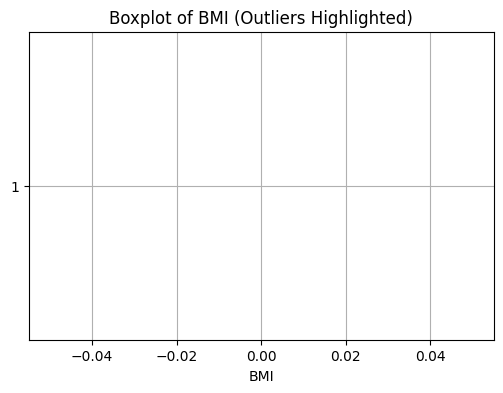

In [20]:
# Step 3: Identify outliers using IQR
Q1 = df['bmi_refined'].quantile(0.25)
Q3 = df['bmi_refined'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add outlier flag
df['is_outlier'] = (df['bmi_refined'] < lower_bound) | (df['bmi_refined'] > upper_bound)

# Step 4: Visualize using boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(df['bmi_refined'], vert=False)
plt.title("Boxplot of BMI (Outliers Highlighted)")
plt.xlabel("BMI")
plt.grid(True)
plt.show()

##### BMI Distribution

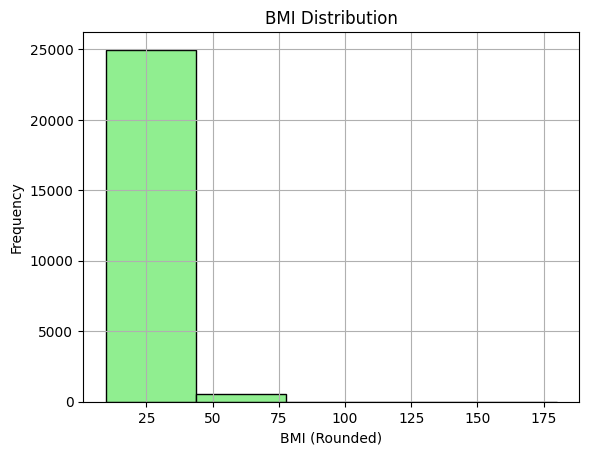

In [21]:
plt.hist(df['bmi_refined'], bins=5, edgecolor='black', color='lightgreen')
plt.xlabel("BMI (Rounded)")
plt.ylabel("Frequency")
plt.title("BMI Distribution")
plt.grid(True)
plt.show()

#### Composite variables

In [22]:
# Process the test data
processed_diet_df = process_diet_data(df)
# df.columns
### Apply the composite variables
df["alcohol_use"] = df.apply(determine_alcohol_use, axis=1)
df["tobacco_use"] = df.apply(determine_tobacco_use, axis=1)

In [ ]:
# # df["hypertension"].value_counts()
# df["stroke"] = df.apply(determine_stroke_xxx, axis=1)
# df["stroke"].value_counts()
# df.columns
print(df['obese_status_derived'].value_counts())
df['stroke_status_derived'].value_counts()

obese_status_derived
0.0    26117
1.0    10527
Name: count, dtype: int64


stroke_status_derived
0.0      42765
1.0       1430
999.0      451
Name: count, dtype: int64

#### SES - individual and categories

In [ ]:
from functools import reduce
### Sociodemographics 

final_df = df[["individual_id"] + sociodemographics + collapse_vars].copy()
# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# df_ind_ses[['hdss_name', 'individual_id', 'obs_date', 'education_level','education_years', 'marital_status', 'currently_working']].head()

df_ind_ses["obs_date"] = pd.to_datetime(df_ind_ses["obs_date"])

# Sort by individual and interview date (latest first)
df_ind_ses_sorted = df_ind_ses.sort_values(by=["individual_id", "obs_date"], ascending=[True, False])

# Pick the first (latest) record per individual for sociodemographic variables
sociodemo_df = df_ind_ses_sorted.drop_duplicates(subset="individual_id", keep="first")[
    ['hdss_name', 'individual_id', 'obs_date', 'education_level',
       'education_years', 'marital_status', 'currently_working']
]

# Merge with processed NCD-level dataset
final_df = sociodemo_df.merge(final_df, on="individual_id", how="inner")
final_df = final_df.merge(processed_diet_df, on="individual_id", how="outer") 

# Fruits intake
# Apply to both variables
final_df['veg_intake_group'] = create_intake_groups(final_df['total_veg_intake'])
final_df['fruit_intake_group'] = create_intake_groups(final_df['total_fruit_intake'])

# --- STEP 4: Save ---
final_df.to_csv("cleaned_data/cleaned_ncd_with_sociodemo_initial.csv", index=False)

In [ ]:
#### Sort records based on Age variable (Starting with the latest record)
df_age = df.sort_values(by=["individual_id", "age"], ascending=[True, False])
# # Pick the first (latest) record per individual for sociodemographic variables
df_age_sorted = df_age.drop_duplicates(subset="individual_id", keep="first")[
    ['individual_id', 'age', 'sex', 'source']
]
# # Merge with processed NCD-level dataset
# final_df = sociodemo_df.merge(final_df, on="individual_id", how="inner")

In [ ]:
df.stroke_status_derived.value_counts()

stroke_status_derived
0.0      42765
1.0       1430
999.0      451
Name: count, dtype: int64

### Missingness

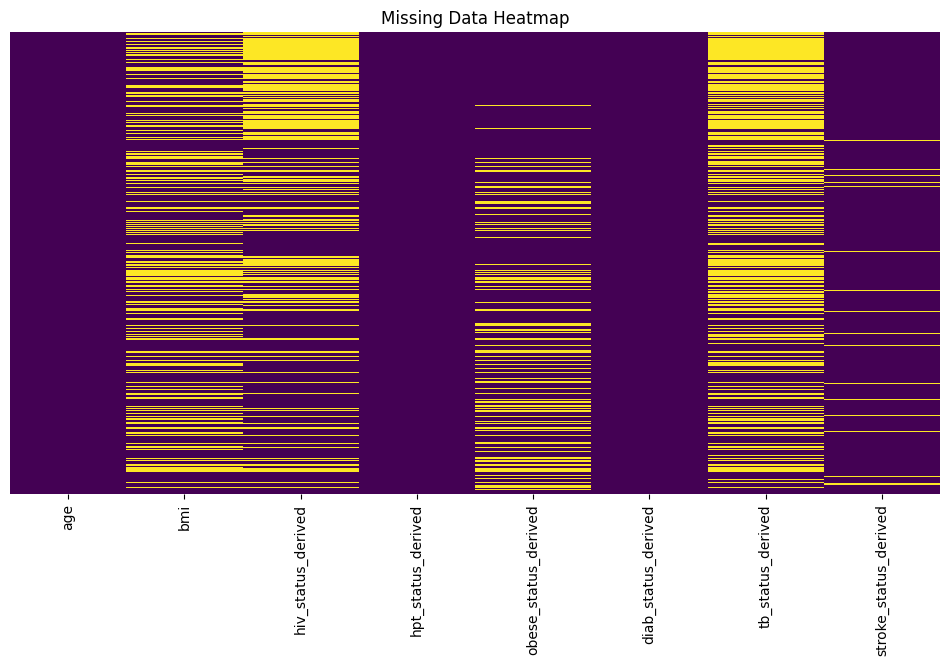

### COLLAPSING: NCDs per individual<br>  

#### Fruit and Vetable groups

In [ ]:
from functools import reduce

# --- STEP 1: Collapse each NCD variable ---
dfs = []
for var in collapse_vars:
    collapsed = collapse_to_ever_had(final_df, "individual_id", var)
    collapsed.columns = ["individual_id", var]
    dfs.append(collapsed)

# Merge all collapsed NCD variables into one dataframe
final_individual_df = reduce(lambda left, right: pd.merge(left, right, on="individual_id", how="outer"), dfs)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# To remove - section

# Sort to get the latest record per individual
final_df_sorted = df.sort_values(by=["individual_id"], ascending=[True])

# # Extract sociodemographic variables from the latest record (disabled this one)
# sociodemo_df = final_df_sorted.drop_duplicates(subset="individual_id", keep="first")[
#     ["individual_id", "age", "sex", "hdss_name"]
# ]

# --- STEP 3: Merge sociodemographic with NCD data ---
final_combined_df = pd.merge(final_individual_df, sociodemo_df, on="individual_id", how="left")
final_combined_df =  final_combined_df.merge(processed_diet_df, on="individual_id", how="outer") 
final_combined_df =  final_combined_df.merge(df_age_sorted, on="individual_id", how="outer") 


df_age_sorted

# Apply to both variables
final_combined_df['veg_intake_group'] = create_intake_groups(final_combined_df['total_veg_intake'])
final_combined_df['fruit_intake_group'] = create_intake_groups(final_combined_df['total_fruit_intake'])

# Verify the grouping
print(final_combined_df['fruit_intake_group'].value_counts().sort_index())
# ----------------------------------------------------------------------------

# --- STEP 4: Save ---
final_combined_df.to_csv("cleaned_data/cleaned_ncd_with_sociodemo.csv", index=False)

fruit_intake_group
0 (None)             11812
1-4 (Very Low)        5052
10-19 (Moderate)      2654
20-29 (High)          1222
30-39 (Very High)      484
40-49 (Extreme)        228
5-9 (Low)             2884
50-59 (Maximum)         91
60+ (Exceptional)       96
Missing (No data)     1069
Name: count, dtype: int64


In [ ]:
# print(final_combined_df.shape)
print(df['obese_status_derived'].value_counts())
df['individual_id'].nunique()
# final_combined_df.head()

obese_status_derived
0.0    26117
1.0    10527
Name: count, dtype: int64


25592

In [ ]:
print(final_combined_df.stroke_status_derived.value_counts())
df.stroke_status_derived.value_counts()

stroke_status_derived
0.0      23132
1.0       1113
999.0       93
Name: count, dtype: int64


stroke_status_derived
0      44748
1       1979
999      678
Name: count, dtype: int64

## Complete records

In [ ]:
#### Stroke numbers 
# df[df['stroke_status_derived']!=999]['stroke_status_derived'].value_counts()
# df[df['stroke_status_derived']!=999]['individual_id'].nunique() # Individuals with stroke data (Yes and No) == 25499
df[df['stroke_status_derived']==1]['individual_id'].nunique() # Number of unique individuals with stroke with the updated dataset == 1113

1094

#### Anchor column (required column)

In [ ]:
features = [
    'age', 'sex', 'bmi', 'hpt_status_derived', 'diab_status_derived' 
    ,'hiv_status_derived', 'obese_status_derived','tb_status_derived'
] #    
# Define all columns required (features + target)
required_columns = ['stroke_status_derived']   # features + ['stroke_status_derived']   # I dont want to remove records based on other variables

# Drop rows with missing values in any of these
df_clean = df.dropna(subset=required_columns)

# Show how many remain
print(f"Remaining records: {len(df_clean)} out of {len(df)}")

Remaining records: 47405 out of 47405


In [ ]:
print('-----------------------df_clean-----------------------------------')
print(df_clean['stroke_status_derived'].value_counts())
print('-----------------------df-----------------------------------------')
df['stroke_status_derived'].value_counts()

-----------------------df_clean-----------------------------------
stroke_status_derived
0.0      42765
1.0       1430
999.0      451
Name: count, dtype: int64
-----------------------df-----------------------------------------


stroke_status_derived
0.0      42765
1.0       1430
999.0      451
Name: count, dtype: int64

In [ ]:
# Additional step 
invalid_codes = [-444, -888, -999, 444, 888, 999]
df_clean_ii = df_clean.replace(invalid_codes, np.nan)
df_clean_ii = df_clean_ii.dropna(subset=required_columns)
# Show how many remain
print(f"Remaining records: {len(df_clean_ii)} out of {len(df)}")

Remaining records: 44195 out of 47405


### Find individuals with conflicting stroke statuses

In [ ]:
# Group by individual_id and count unique stroke statuses
conflicting_stroke = df_clean_ii.groupby('individual_id')['stroke_status_derived'].nunique()

# Filter individuals who have more than one unique value
conflicting_ids = conflicting_stroke[conflicting_stroke > 1].index

# Display their records
df_conflicts = df_clean_ii[df_clean_ii['individual_id'].isin(conflicting_ids)]

# Save dataframe 
df_conflicts.to_csv("cleaned_data/df_conflicts.csv", index=False)
df_for_trajectory = df_clean_ii.copy() # save this copy to run trajectory analysis
df_for_trajectory.to_csv("cleaned_data/df_for_trajectory.csv", index=False)

# Preview
print(df_conflicts.sort_values('individual_id'))

                              individual_id  age  dod  sex    obs_date  \
871    0096A07A-4985-42C1-9A8A-9AF373252EBF   49  NaN    1  2012-11-11   
873    0096A07A-4985-42C1-9A8A-9AF373252EBF   51  NaN    1  2014-11-06   
872    0096A07A-4985-42C1-9A8A-9AF373252EBF   57  NaN    1  2021-03-27   
4753   03A28385-CA4D-4FF6-9E80-1B005B1465B6   52  NaN    2  2012-08-15   
4754   03A28385-CA4D-4FF6-9E80-1B005B1465B6   55  NaN    2  2015-07-15   
...                                     ...  ...  ...  ...         ...   
10986                                 LYZLZ   65  NaN    1  2015-02-26   
10987                                 LYZLZ   70  NaN    1  2020-02-18   
10984                                 LYZLZ   63  NaN    1  2013-10-10   
10982                                 LYZLZ   65  NaN    1  2015-02-26   
10985                                 LYZLZ   71  NaN    1  2021-09-09   

                            source  hdss_name  alco_ever  alco_12m  alco_30d  \
871    SCALEUP Population Basel

In [ ]:
df_clean_ii.stroke_status_derived.value_counts()

stroke_status_derived
0.0    42765
1.0     1430
Name: count, dtype: int64

In [ ]:
df['stroke_status_derived'].value_counts()

stroke_status_derived
0      44748
1       1979
999      678
Name: count, dtype: int64

In [ ]:
df_clean['hdss_name'].value_counts()

hdss_name
Agincourt    32498
Nairobi      14907
Name: count, dtype: int64

### Age function

In [ ]:
import pandas as pd
import numpy as np

def set_condition_ages(df):
    df = df.copy()

    for condition in ['stroke_status_derived', 'hpt_status_derived', 'diab_status_derived','obese_status_derived', 'hiv_status_derived', 'tb_status_derived']:
        age_col = f'{condition}_age'
        df[age_col] = np.nan

        # Get first age where condition == 1 per individual
        first_condition_age = (
            df[df[condition] == 1]
            .groupby('individual_id')['age']
            .min()
        )

        # Get minimum age per individual overall
        # min_age = df.groupby('individual_id')['age'].min()
        
        # Get maximum age per individual (i.e., most recent age observed)
        max_age = df.groupby('individual_id')['age'].max()

        # Map both back to the full DataFrame
        df['first_condition_age_tmp'] = df['individual_id'].map(first_condition_age)
        df['max_age_tmp'] = df['individual_id'].map(max_age)

        # Assign condition_age based on condition status
        df[age_col] = np.where(df[condition] == 1,
                       df['first_condition_age_tmp'],
                       df['max_age_tmp'])

        # Drop temporary columns
        df.drop(columns=['first_condition_age_tmp', 'max_age_tmp'], inplace=True)

    return df



### Updated age function

In [ ]:
import pandas as pd
import numpy as np

def set_condition_ages(df):
    df = df.copy()

    # Sort by individual and date for proper chronological order
    df = df.sort_values(by=['individual_id', 'obs_date'])

    # Conditions to carry forward after first diagnosis
    persistent_conditions = ['stroke_status_derived', 'hpt_status_derived', 'diab_status_derived', 'hiv_status_derived']

    for condition in persistent_conditions:
        age_col = f'{condition}_age'
        df[age_col] = np.nan

        # Step 1: Carry forward once diagnosed (0 → 1 stays 1)
        df[condition] = df.groupby('individual_id')[condition].transform(
            lambda x: x.fillna(0).astype(int).cummax()
        )

        # Step 2: First age at diagnosis (age when condition first becomes 1)
        first_condition_age = (
            df[df[condition] == 1]
            .groupby('individual_id')['age']
            .min()
        )

        # Step 3: Most recent age per individual
        max_age = df.groupby('individual_id')['age'].max()

        # Step 4: Map both to all records
        df['first_condition_age_tmp'] = df['individual_id'].map(first_condition_age)
        df['max_age_tmp'] = df['individual_id'].map(max_age)

        # Step 5: Assign age column
        df[age_col] = np.where(df[condition] == 1,
                               df['first_condition_age_tmp'],
                               df['max_age_tmp'])

        # Clean up temp columns
        df.drop(columns=['first_condition_age_tmp', 'max_age_tmp'], inplace=True)

    return df


In [ ]:
df = set_condition_ages(df)
df.head()

,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,hiv_status_derived_age
27633,000025C5-5811-4942-8957-8A1A4FF1460F,35,NaN,2,2008-07-26,Assess Linkages Main,Nairobi,0.0,NaN,NaN,NaN,0.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,2.0,1.0,-888.0,-888.0,NaN,NaN,12.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,99.0,58.0,4.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0,NaN,NaN,NaN,False,888,0.0,39.0,39.0,39.0,39.0
27634,000025C5-5811-4942-8957-8A1A4FF1460F,39,NaN,2,2012-09-30,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,4.0,7.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-999.0,NaN,0,NaN,NaN,NaN,NaN,888.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0,NaN,25.9187,25.9,False,0,0.0,39.0,39.0,39.0,39.0
10065,0004A623-93CA-4D53-B10C-805B27EFD98F,36,NaN,1,2012-08-26,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,7.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-999.0,NaN,0,NaN,NaN,NaN,NaN,888.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1.0,0,NaN,31.1690,31.2,False,0,0.0,36.0,36.0,36.0,36.0
3767,000D523D-F549-40B3-B8E1-2FF517084EB0,56,NaN,1,2008-04-30,Assess Linkages Main,Nairobi,0.0,NaN,NaN,NaN,0.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-888.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,-888.0,0.0,-888.0,-888.0,NaN,NaN,11.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,113.0,73.0,5.8,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0,NaN,NaN,NaN,False,888,0.0,61.0,56.0,61.0,61.0
3768,000D523D-F549-40B3-B8E1-2FF517084EB0,61,NaN,1,2012-08-24,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,7.0,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN

### Multiple records - Individuals

In [ ]:
# Filter individuals with more than 2 records
df_more_than_2 = df.groupby('individual_id').filter(lambda x: len(x) > 2)

# Select relevant columns
df_more_than_2 = df_more_than_2[['individual_id', 'age', 'stroke_status_derived', 'stroke_status_derived_age',
                                 'hpt_status_derived', 'hpt_status_derived_age',
                                 'diab_status_derived', 'diab_status_derived_age']]

# Sort by individual_id and age
df_more_than_2_sorted = df_more_than_2.sort_values(by=['individual_id', 'age'])

# Preview first 10 rows
df_more_than_2_sorted.head()

,individual_id,age,stroke_status_derived,stroke_status_derived_age,hpt_status_derived,hpt_status_derived_age,diab_status_derived,diab_status_derived_age
27635,000E6165-4313-43DE-BBFE-87581AB48FD4,44,0,53.0,1,44.0,0,53.0
28678,000E6165-4313-43DE-BBFE-87581AB48FD4,46,0,53.0,1,44.0,0,53.0
28677,000E6165-4313-43DE-BBFE-87581AB48FD4,53,0,53.0,1,44.0,0,53.0
7860,00523626-AA3D-4F16-9474-6C22CEC35396,50,0,58.0,1,50.0,0,58.0
7830,00523626-AA3D-4F16-9474-6C22CEC35396,50,999,58.0,1,50.0,999,58.0
7862,00523626-AA3D-4F16-9474-6C22CEC35396,53,999,58.0,1,50.0,999,58.0
7861,00523626-AA3D-4F16-9474-6C22CEC35396,58,999,58.0,1,50.0,999,58.0
19830,00526AF3-829F-49F5-8BBC-A0BB412590C5,34,0,47.0,0,47.0,0,47.0
19831,00526AF3-829F-49F5-8BBC-A0BB412590C5,42,0,47.0,0,47.0,0,47.0
19829,00526AF3-829F-49F5-8BBC-A0BB412590C5,47,0,47.0,0,47.0,0,47.0


### Process conditions Function

In [ ]:
import pandas as pd
import numpy as np

def process_conditions(df, conditions):
    # Copying and sorting the data by when it was collected
    df = df.copy()
    df = df.sort_values(by=['individual_id', 'obs_date'])  # Ensure time order

    # ---------------------------------------------------------
    # 🔹 Step 0: Apply single-record check ONLY for 'stroke_status_derived'
    if 'stroke_status_derived' in df.columns:
        record_counts = df.groupby('individual_id')['stroke_status_derived'].transform('count')
        single_record_mask = record_counts == 1
        invalid_value_mask = ~df['stroke_status_derived'].isin([0, 1])
        df = df[~(single_record_mask & invalid_value_mask)]
    # ---------------------------------------------------------

    for condition in conditions:


        # ----------------------------------------------------------------------------------------
        # Apply forward imputation for selected conditions
        if condition in ["hiv_status_derived", "stroke_status_derived", "diab_status_derived", "hpt_status_derived"]:
            
            # Find first date of positive diagnosis for each person
            first_pos_date = (
                df[df[condition] == 1]
                .groupby('individual_id')['obs_date']
                .min()
            )

            # Map to each record
            df['first_pos_date_tmp'] = df['individual_id'].map(first_pos_date)

            # If record date >= first positive date → set condition to 1
            df.loc[
                (df['first_pos_date_tmp'].notna()) & 
                (df['obs_date'] >= df['first_pos_date_tmp']), 
                condition
            ] = 1

            df.drop(columns=['first_pos_date_tmp'], inplace=True)

        # ----------------------------------------------------------------------------------------


        # Define new column names
        age_col = f'{condition}_age'
        incident_col = f'{condition}_incident'

        # Step 1: Find age of first positive diagnosis
        first_pos_age = (
            df[df[condition] == 1]
            .groupby('individual_id')['age']
            .min()
        )
        df['first_pos_age_tmp'] = df['individual_id'].map(first_pos_age)

        # Step 2: Set age column: first diagnosis age if positive, else current age
        df[age_col] = np.where(df[condition] == 1,
                               df['first_pos_age_tmp'],
                               df['age'])

        # Step 3: Flag incident case (only first time condition becomes 1)
        df[incident_col] = (
            df[condition] == 1
        ) & (
            df['age'] == df['first_pos_age_tmp']
        )
        df[incident_col] = df[incident_col].astype(int)

        # Clean temp
        df.drop(columns=['first_pos_age_tmp'], inplace=True)

    return df


In [ ]:
conditions = [
    'stroke_status_derived',
    'hpt_status_derived',
    'diab_status_derived',
    'hiv_status_derived',
    # 'tb_status_derived',
    # 'obese_status_derived'
]

df_processed = process_conditions(df, conditions)

In [ ]:
# df_processed.head()  
# df_processed.individual_id.nunique()   # df_processed (25501)   #df (25592)
print(df_processed.stroke_status_derived.value_counts())
print(df.stroke_status_derived.value_counts())

stroke_status_derived
0      44748
1       2021
999      545
Name: count, dtype: int64
stroke_status_derived
0      44748
1       1979
999      678
Name: count, dtype: int64


In [ ]:
print(df.columns.tolist())

['individual_id', 'age', 'dod', 'sex', 'obs_date', 'source', 'hdss_name', 'alco_ever', 'alco_12m', 'alco_30d', 'alco_bing_y', 'tobac_ever', 'tobac_cur', 'tobac_smkls_ever', 'tobac_p_daily', 'tobac_freq', 'fd_fruitservings', 'fd_meals_outhome_ave', 'fd_diet_change', 'fd_fruit_days', 'fd_veg_days', 'fd_eat_drink_12h', 'fd_oil_type', 'fd_veg_servings', 'actv_walk_bicycle_days', 'actv_vigorous_sports_min', 'actv_mpa_minutes', 'actv_moderate_sports_hrs', 'actv_vigorous_sports', 'actv_mpa_days', 'actv_vpa_days', 'actv_sitting_or_standing', 'actv_walk_bicycle_min', 'actv_vpa_hrs', 'actv_walk_bicycle_hrs', 'actv_walk_bicycle', 'actv_moderate_sports_days', 'actv_mpa_hrs', 'actv_sitting_min', 'actv_moderate_sports_min', 'actv_sleeping_hrs', 'actv_vigorous_sports_days', 'actv_moderate_sports', 'actv_vpa_minutes', 'actv_vpa', 'actv_mpa', 'actv_vigorous_sports_hrs', 'actv_mvpa', 'actv_sitting_hrs', 'stroke_ever', 'stroke_numb', 'stroke_wkness', 'stroke_paralysis_ever', 'stroke_blind', 'stroke_trans

In [ ]:
df[['individual_id', 'age', 'dod', 'sex', 'obs_date', 'source', 'hdss_name', 'hiv_status_derived', 'obese_status_derived', 'tb_status_derived', 'bmi'
    , 'diab_status_derived', 'diab_status_derived_age', 'hpt_status_derived', 'hpt_status_derived_age','stroke_status_derived'
    ,'obese_status_derived', 'hiv_status_derived', 'hiv_status_derived_age', 'tb_status_derived'
    , 'stroke_status_derived_age']].head()

,individual_id,age,dod,sex,obs_date,source,hdss_name,hiv_status_derived,obese_status_derived,tb_status_derived,bmi,diab_status_derived,diab_status_derived_age,hpt_status_derived,hpt_status_derived_age,stroke_status_derived,obese_status_derived,hiv_status_derived,hiv_status_derived_age,tb_status_derived,stroke_status_derived_age
27633,000025C5-5811-4942-8957-8A1A4FF1460F,35,NaN,2,2008-07-26,Assess Linkages Main,Nairobi,0,0.0,NaN,NaN,0,39.0,0,39.0,0,0.0,0,39.0,NaN,39.0
27634,000025C5-5811-4942-8957-8A1A4FF1460F,39,NaN,2,2012-09-30,SCALEUP Population Baseline,Nairobi,0,0.0,NaN,25.9187,0,39.0,1,39.0,0,0.0,0,39.0,NaN,39.0
10065,0004A623-93CA-4D53-B10C-805B27EFD98F,36,NaN,1,2012-08-26,SCALEUP Population Baseline,Nairobi,0,1.0,NaN,31.1690,0,36.0,1,36.0,0,1.0,0,36.0,NaN,36.0
3767,000D523D-F549-40B3-B8E1-2FF517084EB0,56,NaN,1,2008-04-30,Assess Linkages Main,Nairobi,0,0.0,NaN,NaN,0,61.0,1,56.0,0,0.0,0,61.0,NaN,61.0
3768,000D523D-F549-40B3-B8E1-2FF517084EB0,61,NaN,1,2012-08-24,SCALEUP Population Baseline,Nairobi,0,1.0,NaN,32.6677,0,61.0,1,56.0,0,1.0,0,61.0,NaN,61.0
27635,000E6165-4313-43DE-BBFE-87581AB48FD4,44,NaN,1,2012-12-15,SCALEUP Population Baseline,Nairobi,0,0.0,NaN,28.5483,0,53.0,1,44.0,0,0.0,0,53.0,NaN,53.0
28678,000E6165-4313-43DE-BBFE-87581AB48FD4,46,NaN,1,2014-11-16,AWIGEN_1,Nairobi,1,0.0,0.0,22.7400,0,53.0,1,44.0,0,0.0,1,46.0,0.0,53.0
28677,000E6165-4313-43DE-BBFE-87581AB48FD4,53,NaN,1,2021-06-01,AWIGEN_2,Nairobi,1,1.0,0.0,30.7100,0,53.0,1,44.0,0,1.0,1,46.0,0.0,53.0
40446,000EE8FA-5B5B-4917-9CF9-D15A41AF1765,55,NaN,1,2008-05-28,Assess Linkages Main,Nairobi,0,0.0,NaN,NaN,0,60.0,0,60.0,0,0.0,0,60.0,NaN,60.0
40445,000EE8FA-5B5B-4917-9CF9-D15A41AF1765,60,NaN,1,2012-10-02,SCALEUP Population Baseline,Nairobi,0,1.0,NaN,32.3884,0,60.0,1,60.0,0,1.0,0,60.0,NaN,60.0


In [ ]:
df.loc[df['individual_id'] == '000E6165-4313-43DE-BBFE-87581AB48FD4', [
    'individual_id', 'age', 'dod', 'sex', 'obs_date', 'source', 'hdss_name'
    ,'bmi'
    ,'hiv_status_derived', 'hiv_status_derived_age'
    ,'obese_status_derived'
    ,'tb_status_derived'
    ,'hpt_status_derived', 'hpt_status_derived_age'
    ,'diab_status_derived', 'diab_status_derived_age'
    ,'stroke_status_derived','stroke_status_derived_age'
]]


,individual_id,age,dod,sex,obs_date,source,hdss_name,bmi,hiv_status_derived,hiv_status_derived_age,obese_status_derived,tb_status_derived,hpt_status_derived,hpt_status_derived_age,diab_status_derived,diab_status_derived_age,stroke_status_derived,stroke_status_derived_age
27635,000E6165-4313-43DE-BBFE-87581AB48FD4,44,NaN,1,2012-12-15,SCALEUP Population Baseline,Nairobi,28.5483,0,53.0,0.0,NaN,1,44.0,0,53.0,0,53.0
28678,000E6165-4313-43DE-BBFE-87581AB48FD4,46,NaN,1,2014-11-16,AWIGEN_1,Nairobi,22.7400,1,46.0,0.0,0.0,1,44.0,0,53.0,0,53.0
28677,000E6165-4313-43DE-BBFE-87581AB48FD4,53,NaN,1,2021-06-01,AWIGEN_2,Nairobi,30.7100,1,46.0,1.0,0.0,1,44.0,0,53.0,0,53.0


#### Validation

In [ ]:
df_processed.loc[df['individual_id'] == 'HMMYW', [
    'individual_id', 'age', 'dod', 'sex', 'obs_date', 'source', 'hdss_name'
    ,'bmi'
    ,'hiv_status_derived', 'hiv_status_derived_age'
    ,'obese_status_derived'
    ,'tb_status_derived'
    ,'hpt_status_derived', 'hpt_status_derived_age'
    ,'diab_status_derived', 'diab_status_derived_age'
    ,'stroke_status_derived','stroke_status_derived_age'
]]

'0159DACE-4343-40EF-A8CD-0116461BA2B6'

,individual_id,age,dod,sex,obs_date,source,hdss_name,bmi,hiv_status_derived,hiv_status_derived_age,obese_status_derived,tb_status_derived,hpt_status_derived,hpt_status_derived_age,diab_status_derived,diab_status_derived_age,stroke_status_derived,stroke_status_derived_age
1604,HMMYW,39,NaN,2,2011-01-25,HIV_NCD,Agincourt,NaN,1,39.0,0.0,NaN,1,39.0,0,39.0,0,39.0
1606,HMMYW,43,NaN,2,2015-05-07,HAALSI_1,Agincourt,26.9029,1,39.0,1.0,0.0,1,39.0,0,43.0,0,43.0
1608,HMMYW,43,NaN,2,2015-05-07,AWIGEN_1,Agincourt,26.6800,1,39.0,0.0,0.0,1,39.0,0,43.0,0,43.0
1605,HMMYW,47,NaN,2,2019-02-02,HAALSI_2,Agincourt,27.9096,1,39.0,0.0,0.0,1,39.0,0,47.0,0,47.0
1609,HMMYW,49,NaN,2,2021-02-17,AWIGEN_2,Agincourt,26.8290,1,39.0,0.0,0.0,1,39.0,0,49.0,0,49.0
1607,HMMYW,50,NaN,2,2021-11-18,HAALSI_3,Agincourt,20.7813,1,39.0,0.0,0.0,1,39.0,0,50.0,0,50.0


### Save the dataframes

In [ ]:
df_processed = df_processed[df_processed['stroke_status_derived'].isin([0, 1])]

In [ ]:
df_processed.to_csv("cleaned_data/df_processed.csv", index=False)
# df_bmi.to_csv("cleaned_data/df_bmi.csv", index=False)
# final_combined_df.to_csv("cleaned_data/cleaned_ncd_with_sociodemo.csv", index=False)
# df.shape

In [ ]:
# df_processed.stroke_status_derived.value_counts()
print(df_processed.individual_id.nunique())
df_processed[df_processed.stroke_status_derived==1].individual_id.nunique()  # Stroke status as 'yes'

25486


1094

Notes 28-7-2025
Additions:
1. There is a step we altered a bit to ensure that we are not dropping data that could be a value addition to our analysis.
Before dropping all records with 999 or other values other than 0 and 1 for stroke (target variable), we first imputed the stroke status for individuals with multiple records with a previous one indicating a yes for stroke.
2. How do we deal with stroke statuses for an individual who has never been diagnosed? Check '00523626-AA3D-4F16-9474-6C22CEC35396'
Another example '00523626-AA3D-4F16-9474-6C22CEC35396' - look at the diabetes status and stroke status
3. TB and obesity status does not affect preceeding data points.

In [ ]:
df_processed.head()

,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,hiv_status_derived_age,stroke_status_derived_incident,hpt_status_derived_incident,diab_status_derived_incident,hiv_status_derived_incident
27633,000025C5-5811-4942-8957-8A1A4FF1460F,35,NaN,2,2008-07-26,Assess Linkages Main,Nairobi,0.0,NaN,NaN,NaN,0.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,2.0,1.0,-888.0,-888.0,NaN,NaN,12.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,99.0,58.0,4.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0,NaN,NaN,NaN,False,888,0.0,35.0,35.0,35.0,35.0,0,0,0,0
27634,000025C5-5811-4942-8957-8A1A4FF1460F,39,NaN,2,2012-09-30,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,4.0,7.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-999.0,NaN,0,NaN,NaN,NaN,NaN,888.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0,NaN,25.9187,25.9,False,0,0.0,39.0,39.0,39.0,39.0,0,1,0,0
10065,0004A623-93CA-4D53-B10C-805B27EFD98F,36,NaN,1,2012-08-26,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,7.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-999.0,NaN,0,NaN,NaN,NaN,NaN,888.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1.0,0,NaN,31.1690,31.2,False,0,0.0,36.0,36.0,36.0,36.0,0,1,0,0
3767,000D523D-F549-40B3-B8E1-2FF517084EB0,56,NaN,1,2008-04-30,Assess Linkages Main,Nairobi,0.0,NaN,NaN,NaN,0.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-888.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,-888.0,0.0,-888.0,-888.0,NaN,NaN,11.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,113.0,73.0,5.8,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0,NaN,NaN,NaN,False,888,0.0,56.0,56.0,56.0,56.0,0,1,0,0
3768,000D523D-F549-40B3-B8E1-2FF517084EB0,61,NaN,1,2012-08-24,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,7.0,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN